# Трассировка лучей


## Подключаем библиотеки и описываем вспомогательные функции

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

eps = 2**(-10)
tiny_eps = eps**2

class empty():
    def __init__(self):
        return None
    
class endles_none:
    def __init__(self, n):
        self.n = n
        return None
    def __iter__(self):
        return endles_none(self.n)
    def __next__(self):
        if self.n <= 0:
            raise StopIteration
        else:
            self.n -= 1
        return None
    
def none_func(n):
    def function(*args, **kwargs):
        if n > 1:
            return endles_none(n)
        elif n == 1:
            return None
        else:
            raise ValueError
    return function

def const_func(const):
    def function(*args, **kwargs):
        return const
    return function

def normalize(x):
    x /= np.linalg.norm(x)
    return x

def smooth_max(x, y, alpha):
    return (x*np.exp(alpha*x) + y*np.exp(alpha*y))/(np.exp(alpha*x) + np.exp(alpha*y))

## Алгоритмы отрисовки и трассировки

In [2]:
def render_image (camera, scene, screen, *, status = 5, depth=5):
    w = screen.w
    h = screen.h
    
    image = np.zeros((h, w, 3))
    
    # ----- status output -----
    procents = 0
    if 0 < status <= 100:
        print(0,'%')
        start_t = time.time()
        last_t = start_t
        
    for i in range(h):
        for k in range(w):
            pixel_pos = camera.position + camera.orientate + camera.delta*(camera.dx*(k - w/2) + camera.dy*(h/2 - i))
            ray = normalize(pixel_pos - camera.position)
            
            image[i][k] = trace_ray(scene, pixel_pos, ray, depth)
        
        # ----- status output -----
        if 0 < status <= 100:
            if procents < ((i/h)*100) // status:
                tmp = time.time()
                print(i/h*100,'% dt -', tmp - last_t)
                last_t = tmp
                procents = ((i/h)*100) // status
    # ----- status output -----
    if 0 < status <= 100:
        end_t = time.time()
        print(100,'% time -', end_t - start_t)
    
    return image

def trace_ray (scene, start, ray, depth=5, significance=1, weight=1):
    ans = np.zeros(3)
    if depth <= 0:
        return ans

    light = np.array([3.0, 6, -10.0])
    
    color = np.ones((3))
    alpha = 0.4
    normal, dist = scene.get_normal(start, ray)
    if normal is not None:
        point = start + ray*dist
        if point[1] < eps:
            color = np.cos(point)**2;
            alpha = 0.8;
        else:
            alpha = 0.3;
            
        tmp = np.sum(normalize(light-point) * normal)
        if tmp < 0:
            tmp *= -1
        _, light_dist = scene.get_normal(point + normalize(light-point)*eps, normalize(light-point))
        if light_dist > np.linalg.norm(light-point):
            ans += color * tmp * alpha
            
        if (1-alpha) > 0:
            ray -= 2*normal*np.sum(normal*ray)
            ans += (1-alpha) *trace_ray(scene, point + eps*ray, ray, depth-1)
    return ans

## Описание объектов сцены

In [3]:
class render_object:
    def __init__(self, *args, **kwargs):
        if 'get_normal' in kwargs.keys():
            self.get_normal = kwargs['get_normal']
        if 'get_intersection' in kwargs.keys():
            self.get_intersection = kwargs['get_intersection']
        if 'get_color' in kwargs.keys():
            self.get_color = kwargs['get_color']
        return None

class scene:
    def __init__(self, render_objects):
        self.objects = render_objects
        self.last_object = None
        return None
    
    def get_normal(self, start, ray):
        normal = None
        distance = np.inf
        for obj in self.objects:
            tmp_normal, tmp_distance = obj.get_normal(start, ray)
            if tmp_distance < distance:
                distance = tmp_distance
                normal = tmp_normal
        return normal, distance

def sphere(Position, R):
    def normal(start, ray):
        a = np.dot(ray, ray)
        PS = start - Position
        b = 2 * np.dot(ray, PS)
        c = np.dot(PS, PS) - R * R
        disc = b * b - 4 * a * c
        if disc > 0:
            distSqrt = np.sqrt(disc)
            q = (-b - distSqrt) / 2.0 if b < 0 else (-b + distSqrt) / 2.0
            t0 = q / a
            t1 = c / q
            t0, t1 = min(t0, t1), max(t0, t1)
            if t1 >= 0:
                if t0 < 0:
                    return normalize(start + ray*t1 - Position), t1
                else:
                    return normalize(start + ray*t0 - Position), t0
        return None, np.inf
    return normal

def plane(Position, Direction):
    Direction = normalize(Direction)
    def normal(start, ray):
        if np.sum((Position - start) * Direction) * np.sum(ray * Direction) <= 0:
            return None, np.inf
        else:
            return Direction, np.sum((Position - start) * Direction)/np.sum(ray * Direction)
    return normal

## Задание сцены

In [4]:
'''
    ^ y
    |
    |
    |
    o--------> x
   /
  /
 /
L z
'''
objs = np.array([
    render_object(get_normal = sphere(np.array([11,2.5,-7]), 2.5)),
    render_object(get_normal = sphere(np.array([13,5,9]), 5)),
    render_object(get_normal = sphere(np.array([17,5,-1]), 5)),
    render_object(get_normal = plane(np.array([20,13,9]), np.array([-4.0,-5.0,-1.0]))),
    render_object(get_normal = plane(np.array([0,0,0]), np.array([0.0,1.0,0.0])))
])

my_scene = scene(objs)

## Описание камеры

In [5]:
my_camera = empty()
my_camera.position = np.array([0.0, 4.4, 0.0])
my_camera.orientate = np.array([0.1, 0, 0])
my_camera.dx = np.array([0.0, 0.0, 1.0])
my_camera.dy = np.array([0.0, 1.0, 0.0])
my_camera.delta = 0.001

camera_screen = empty()
camera_screen.w = 300
camera_screen.h = 179

## Просчитываем сцену

0 %
5.027932960893855 % dt - 2.44992995262146
10.05586592178771 % dt - 2.230747938156128
15.083798882681565 % dt - 2.2502527236938477
20.11173184357542 % dt - 2.7183849811553955
25.139664804469277 % dt - 2.956620216369629
30.16759776536313 % dt - 2.6907663345336914
35.19553072625698 % dt - 2.6623308658599854
40.22346368715084 % dt - 2.4090819358825684
45.2513966480447 % dt - 2.253554582595825
50.27932960893855 % dt - 2.268174171447754
55.3072625698324 % dt - 2.7921314239501953
60.33519553072626 % dt - 3.064316511154175
65.36312849162012 % dt - 3.6362521648406982
70.39106145251397 % dt - 4.106502056121826
75.41899441340783 % dt - 3.9958086013793945
80.44692737430168 % dt - 3.691593885421753
85.47486033519553 % dt - 3.16324520111084
90.5027932960894 % dt - 2.736231565475464
95.53072625698324 % dt - 2.7476272583007812
100 % time - 56.95454716682434


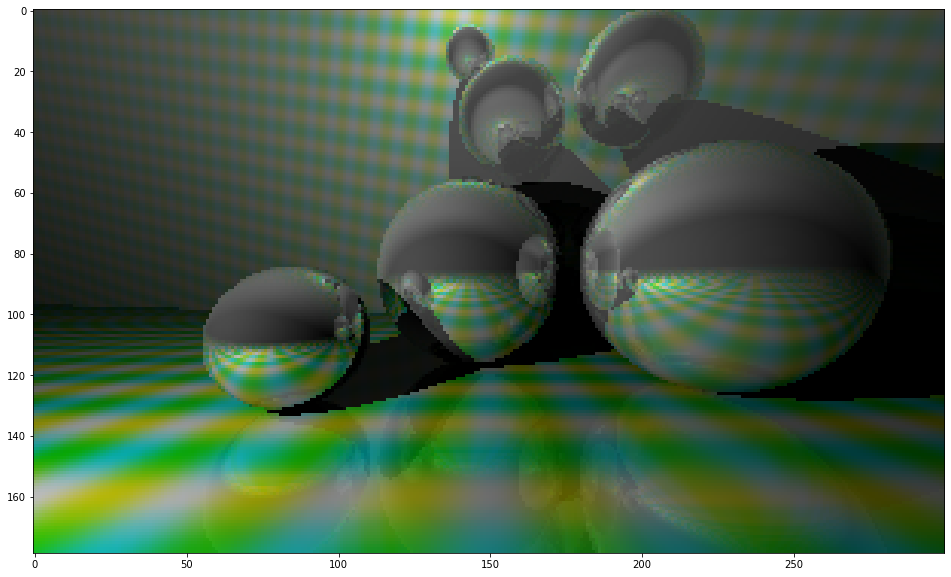

In [6]:
img = render_image(my_camera, my_scene, camera_screen, depth = 20)

#plt.imsave('tmp.png', img)
plt.figure(figsize=(20,10))
plt.imshow(img)

### Немного кода для теста

In [255]:
def smooth_max(x, y, alpha):
    return (x*np.exp(alpha*x) + y*np.exp(alpha*y))/(np.exp(alpha*x) + np.exp(alpha*y))

class SDF_function:
    def __init__(self, func):
        self.distance = func
        return None
    
    def __call__(self, *args, **kwargs):
        return self.distance(*args, **kwargs)
    
    def __add__(self, other):
        def func(*args, **kwargs):
            return min(self.distance(*args, **kwargs), other.distance(*args, **kwargs))
        return SDF_function(func)
    
    def __mul__(self, other):
        def func(*args, **kwargs):
            return max(self.distance(*args, **kwargs), other.distance(*args, **kwargs))
        return SDF_function(func)
    
    def __sub__(self, other):
        def func(*args, **kwargs):
            return max(self.distance(*args, **kwargs), -other.distance(*args, **kwargs))
        return SDF_function(func)
    
    def smooth(self, other, alpha=0):
        def func(*args, **kwargs):
            return smooth_max(self.distance(*args, **kwargs), other.distance(*args, **kwargs), alpha)
        return SDF_function(func)

In [284]:
tmp1 = SDF_function(lambda x,y : ((x+1.5)*(x+1.5)+y*y)**(0.5)-1.5)
tmp2 = SDF_function(lambda x,y : ((x)*(x)+(y)*(y))**(0.5)-2)
tmp3 = SDF_function(lambda x,y : ((x-1.5)*(x-1.5)+(y)*(y))**(0.5)-1)
tmp4 = tmp1.smooth(tmp2, 0.1).smooth(tmp3, -3)

In [117]:
tmp3(1,2)

4.5397868702434395e-05

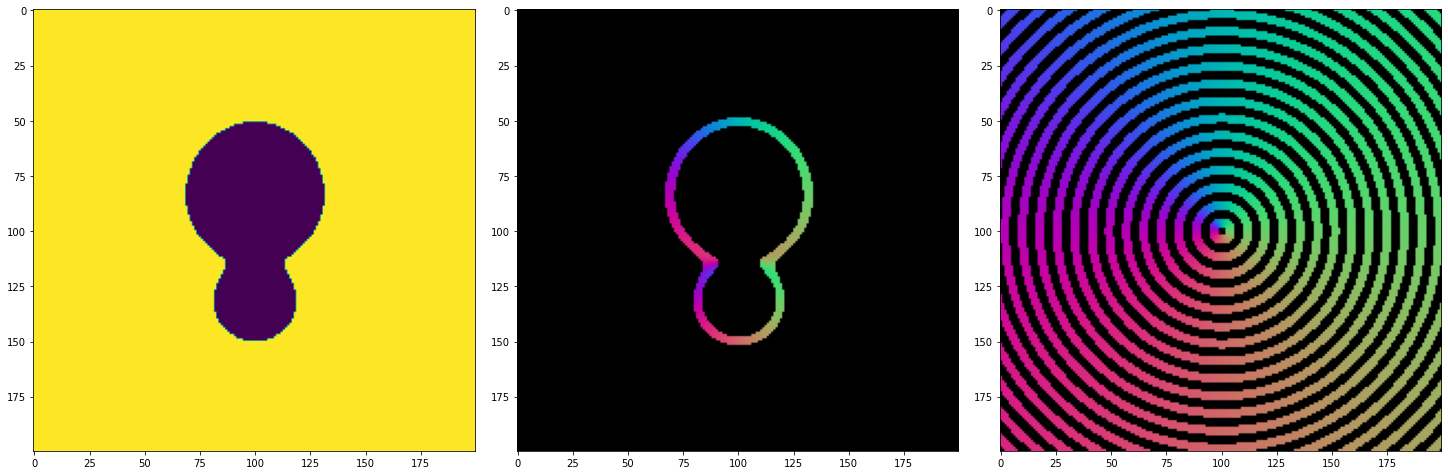

In [317]:
import matplotlib.gridspec as gridspec
scale = 20
t_img = np.zeros((10*scale, 10*scale))
tmp_img = np.zeros((10*scale, 10*scale, 3))
dir_img = np.zeros((10*scale, 10*scale, 3))
for i in range(10*scale):
    for k in range(10*scale):
        x = i/scale - 5
        y = k/scale - 5
        if tmp4(x, y) > 0:
            t_img[i][k] = 1
        else:
            t_img[i][k] = -1
        if  -0.1 < tmp4(x, y) < 0.1:
            tmp_img[i][k][0] = (tmp4(x+eps,y)-tmp4(x-eps,y))/(2*eps)
            tmp_img[i][k][1] = (tmp4(x,y+eps)-tmp4(x,y-eps))/(2*eps)
            tmp_img[i][k] = np.ones(3) + normalize(tmp_img[i][k])
            tmp_img[i][k] = normalize(tmp_img[i][k])
        if -0.707 < np.cos(8*(x*x+y*y)**0.5) < 0.707:
            dir_img[i][k] = np.array([x,y,0])
            dir_img[i][k] = np.ones(3) + normalize(dir_img[i][k])
            dir_img[i][k] = normalize(dir_img[i][k])
            
            
fig2 = plt.figure(constrained_layout=True, figsize=(20,10))
spec2 = gridspec.GridSpec(nrows=1, ncols=3, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0, 0])
f2_ax2 = fig2.add_subplot(spec2[0, 1])
f2_ax3 = fig2.add_subplot(spec2[0, 2])
f2_ax1.imshow(t_img)
f2_ax2.imshow(tmp_img)
f2_ax3.imshow(dir_img)